In [4]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os, time
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
# import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load data

In [5]:
subj = '8 rdc' # '8 rdc', 'orig', '8ch'
subj = '8ch' # '8 rdc', 'orig', '8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
# filename = 'ASL_Datasets/'+subj+'_spec_128_resized_final.pkl'
# filename = '../Datasets/'+subj+'_spec_128_zeropad.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_orig_tr, x_orig_ts, y_tr, y_ts = [x[0], x[1], x[2], x[3]]

y_tr_temp = [y_tr[i] for i in range(len(y_tr)) if y_tr[i] in list(range(11))] 
x_tr_temp = [x_orig_tr[i] for i in range(len(y_tr)) if y_tr[i] in list(range(11))] 
y_ts_temp = [y_ts[i] for i in range(len(y_ts)) if y_ts[i] in list(range(11))] 
x_ts_temp = [x_orig_ts[i] for i in range(len(y_ts)) if y_ts[i] in list(range(11))] 

x_orig_tr = np.array(x_tr_temp)
x_orig_ts = np.array(x_ts_temp)

y_tr = to_categorical(np.array(y_tr_temp)-1)
y_ts = to_categorical(np.array(y_ts_temp)-1)

print(x_orig_tr.shape)
print(x_orig_ts.shape)
print(y_tr.shape)
print(y_ts.shape)

(404, 128, 128, 24)
(98, 128, 128, 24)
(404, 10)
(98, 10)


In [6]:
# single vs one handed
singles = [0,1,3,11]  
y_tr_hand = [1 if v not in singles else 0 for i, v in enumerate(np.argmax(y_tr,-1))]
y_ts_hand = [1 if v not in singles else 0 for i, v in enumerate(np.argmax(y_ts,-1))]

y_tr_hand = to_categorical(np.array(y_tr_hand))
y_ts_hand = to_categorical(np.array(y_ts_hand)) 
print(y_tr_hand.shape)
print(y_ts_hand.shape)
print(Counter(np.argmax(y_tr_hand,-1)))

(404, 2)
(98, 2)
Counter({1: 274, 0: 130})


In [7]:
# plt.figure(dpi=150)
# plt.imshow(x_orig_tr[0,:,:,0]*255)
# plt.savefig('zeropadded.png')
# # fig = plt.gcf()

In [8]:
# subj = '0 60 left'
subj = '0 60 left 8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_060left_tr, x_060left_ts, y_tr2, y_ts2 = [x[0], x[1], x[2], x[3]]
# y_tr2, y_ts2 = [to_categorical(x[2]-1), to_categorical(x[3]-1)]


y_tr_temp = [y_tr2[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
y_ts_temp = [y_ts2[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]
x_tr_temp = [x_060left_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
x_ts_temp = [x_060left_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

x_060left_tr = np.array(x_tr_temp)
x_060left_ts = np.array(x_ts_temp)

print(x_060left_tr.shape)
print(x_060left_ts.shape)

# subj = '0 60 right'
subj = '0 60 right 8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_060right_tr, x_060right_ts = [x[0], x[1]]

x_tr_temp = [x_060right_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
x_ts_temp = [x_060right_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

x_060right_tr = np.array(x_tr_temp)
x_060right_ts = np.array(x_ts_temp)

print(x_060right_tr.shape)
print(x_060right_ts.shape)

# subj = '30 60 left'
subj = '30 60 left 8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_3060left_tr, x_3060left_ts = [x[0], x[1]]

x_tr_temp = [x_3060left_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
x_ts_temp = [x_3060left_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

x_3060left_tr = np.array(x_tr_temp)
x_3060left_ts = np.array(x_ts_temp)

print(x_3060left_tr.shape)
print(x_3060left_ts.shape)

# subj = '30 60 right'
subj = '30 60 right 8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_3060right_tr, x_3060right_ts = [x[0], x[1]]

x_tr_temp = [x_3060right_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
x_ts_temp = [x_3060right_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

x_3060right_tr = np.array(x_tr_temp)
x_3060right_ts = np.array(x_ts_temp)


y_tr2 = to_categorical(np.array(y_tr_temp)-1)
y_ts2 = to_categorical(np.array(y_ts_temp)-1)

print(x_3060right_tr.shape)
print(x_3060right_ts.shape)

(404, 128, 128, 24)
(98, 128, 128, 24)
(404, 128, 128, 24)
(98, 128, 128, 24)
(404, 128, 128, 24)
(98, 128, 128, 24)
(404, 128, 128, 24)
(98, 128, 128, 24)


In [9]:
subj = '0 30 left 8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_030left_tr, x_030left_ts, y_tr2, y_ts2 = [x[0], x[1], x[2], x[3]]
# y_tr2, y_ts2 = [to_categorical(x[2]-1), to_categorical(x[3]-1)]

y_tr_temp = [y_tr2[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
y_ts_temp = [y_ts2[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]
x_tr_temp = [x_030left_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
x_ts_temp = [x_030left_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

x_030left_tr = np.array(x_tr_temp)
x_030left_ts = np.array(x_ts_temp)

print(x_030left_tr.shape)
print(x_030left_ts.shape)

subj = '0 30 right 8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_030right_tr, x_030right_ts = [x[0], x[1]]

x_tr_temp = [x_030right_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
x_ts_temp = [x_030right_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

x_030right_tr = np.array(x_tr_temp)
x_030right_ts = np.array(x_ts_temp)

print(x_030right_tr.shape)
print(x_030right_ts.shape)

subj = '60 90 left 8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_6090left_tr, x_6090left_ts = [x[0], x[1]]

x_tr_temp = [x_6090left_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
x_ts_temp = [x_6090left_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

x_6090left_tr = np.array(x_tr_temp)
x_6090left_ts = np.array(x_ts_temp)

print(x_6090left_tr.shape)
print(x_6090left_ts.shape)

subj = '60 90 right 8ch'
filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
x_6090right_tr, x_6090right_ts = [x[0], x[1]]

x_tr_temp = [x_6090right_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
x_ts_temp = [x_6090right_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

x_6090right_tr = np.array(x_tr_temp)
x_6090right_ts = np.array(x_ts_temp)

y_tr2 = to_categorical(np.array(y_tr_temp)-1)
y_ts2 = to_categorical(np.array(y_ts_temp)-1)

print(x_6090right_tr.shape)
print(x_6090right_ts.shape)

(404, 128, 128, 24)
(98, 128, 128, 24)
(404, 128, 128, 24)
(98, 128, 128, 24)
(404, 128, 128, 24)
(98, 128, 128, 24)
(404, 128, 128, 24)
(98, 128, 128, 24)


In [10]:
num_class = y_tr.shape[-1]
print('num_class:', num_class)
batch_size = 128//4
epochs = 200
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)

num_class: 10


In [11]:
def orig_model():
    inputlayer1 = Input(shape = (x_orig_tr.shape[1],x_orig_tr.shape[2],x_orig_tr.shape[3]))
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    out1 = Dense(num_class,activation='softmax')(x)
    model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
    return model 

In [12]:
def multi_model():
    inputlayer1 = Input(shape = (x_060right_tr.shape[1],x_060right_tr.shape[2],x_060right_tr.shape[3]))
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    
    inputlayer2 = Input(shape = (x_060right_tr.shape[1],x_060right_tr.shape[2],x_060right_tr.shape[3]))
    y = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer2)
    y = MaxPooling2D(pool_size=(2,2))(y)
    y = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(y)
    y = MaxPooling2D(pool_size=(2,2))(y)
    y = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(y)
    y = MaxPooling2D(pool_size=(2,2))(y)
    y = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(y)
    y = MaxPooling2D(pool_size=(2,2))(y)
    y = Flatten()(y)
    z = concatenate([x,y],-1)
    
    out1 = Dense(num_class,activation='softmax')(z)
    model = keras.Model(inputs = [inputlayer1,inputlayer2], outputs = [out1])#, out2, out3])
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
    return model 

In [13]:
def shared_multi_model():
    
    inputlayer = Input(shape = (x_060right_tr.shape[1],x_060right_tr.shape[2],x_060right_tr.shape[3]))
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    shared_cnn = keras.Model(inputs = [inputlayer], outputs = [x])#, out2, out3])
    
    inputlayer1 = Input(shape = (x_060right_tr.shape[1],x_060right_tr.shape[2],x_060right_tr.shape[3]))
    inputlayer2 = Input(shape = (x_060right_tr.shape[1],x_060right_tr.shape[2],x_060right_tr.shape[3]))
    
    encoded1 = shared_cnn(inputlayer1)
    encoded2 = shared_cnn(inputlayer2)
    
    z = concatenate([encoded1,encoded2],-1)
    out1 = Dense(num_class,activation='softmax')(z)
    
    model = keras.Model(inputs = [inputlayer1,inputlayer2], outputs = [out1])#, out2, out3])
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
    return model 

## Orig

In [14]:
accs = []
best_acc = 0
subj = 'single'
for i in range(5):
    t = time.time()
    model = orig_model()
    history = model.fit(
        x_orig_tr,y_tr,
        validation_data=(x_orig_ts,y_ts),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate(x_orig_ts,y_ts,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = subj
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9285714030265808 , elapsed time:  0.297484290599823  minutes.
Acc:  0.918367326259613 , elapsed time:  0.30315115054448444  minutes.
Acc:  0.918367326259613 , elapsed time:  0.2934557994206746  minutes.
Acc:  0.9591836929321289 , elapsed time:  0.273400092124939  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.26253575483957925  minutes.
Mean:  0.9326530575752259 , STD:  0.015272089172158197


In [36]:
# # save model
# fname = 'orig md hand'
# MODEL_FILE = '../models/' + fname + '.json' # save path
# WEIGHT_FILE = '../models/' + fname + '.h5' # save path

# model_json = model.to_json()
# with open(MODEL_FILE, "w") as json_file:
#     json_file.write(model_json)
# model.save_weights(WEIGHT_FILE)

In [37]:
# loss, acc = model.evaluate(x_orig_ts,y_ts_hand)

## 0 to 60

In [59]:
accs = []
best_acc = 0
for i in range(5):
    t = time.time()
    model = multi_model()
    history = model.fit(
        [x_060right_tr,x_060left_tr],y_tr2,
        validation_data=([x_060right_ts,x_060left_ts],y_ts2),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate([x_060right_ts,x_060left_ts],y_ts2,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = '0to60 8ch'
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9489796161651611 , elapsed time:  0.3429799755414327  minutes.
Acc:  0.9795918464660645 , elapsed time:  0.363760503133138  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.4068618615468343  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.34062380393346153  minutes.
Acc:  0.9489796161651611 , elapsed time:  0.380445929368337  minutes.
Mean:  0.9510204315185546 , STD:  0.014996868825155817


## 30 to 60

In [60]:
accs = []
best_acc = 0
for i in range(5):
    t = time.time()
    model = multi_model()
    history = model.fit(
        [x_3060right_tr,x_3060left_tr],y_tr2,
        validation_data=([x_3060right_ts,x_3060left_ts],y_ts2),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate([x_3060right_ts,x_3060left_ts],y_ts2,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = '30to60 8ch'
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9591836929321289 , elapsed time:  0.3501011967658997  minutes.
Acc:  0.9285714030265808 , elapsed time:  0.3472742279370626  minutes.
Acc:  0.9285714030265808 , elapsed time:  0.34618297417958577  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.358697505791982  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.3597280979156494  minutes.
Mean:  0.9387755155563354 , STD:  0.011178027812121207


# 0 to 30

In [62]:
accs = []
best_acc = 0
for i in range(5):
    t = time.time()
    model = multi_model()
    history = model.fit(
        [x_030right_tr,x_030left_tr],y_tr2,
        validation_data=([x_030right_ts,x_030left_ts],y_ts2),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate([x_030right_ts,x_030left_ts],y_ts2,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = '0to30 8ch'
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9693877696990967 , elapsed time:  0.405400288105011  minutes.
Acc:  0.9693877696990967 , elapsed time:  0.3680272102355957  minutes.
Acc:  0.9795918464660645 , elapsed time:  0.42656469345092773  minutes.
Acc:  0.9591836929321289 , elapsed time:  0.32704281409581504  minutes.
Acc:  0.9693877696990967 , elapsed time:  0.33033942778905234  minutes.
Mean:  0.9693877696990967 , STD:  0.006453624800565074


# 60 to 90

In [63]:
accs = []
best_acc = 0
for i in range(5):
    t = time.time()
    model = multi_model()
    history = model.fit(
        [x_6090right_tr,x_6090left_tr],y_tr2,
        validation_data=([x_6090right_ts,x_6090left_ts],y_ts2),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate([x_6090right_ts,x_6090left_ts],y_ts2,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = '60to90 8ch'
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9489796161651611 , elapsed time:  0.3761320432027181  minutes.
Acc:  0.9081632494926453 , elapsed time:  0.35719022353490193  minutes.
Acc:  0.9591836929321289 , elapsed time:  0.3807805816332499  minutes.
Acc:  0.918367326259613 , elapsed time:  0.3963431159655253  minutes.
Acc:  0.9285714030265808 , elapsed time:  0.3451430082321167  minutes.
Mean:  0.9326530575752259 , STD:  0.01892577000192874


# 0 to 30 shared

In [64]:
accs = []
best_acc = 0
for i in range(5):
    t = time.time()
    model = shared_multi_model()
    history = model.fit(
        [x_030right_tr,x_030left_tr],y_tr2,
        validation_data=([x_030right_ts,x_030left_ts],y_ts2),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate([x_030right_ts,x_030left_ts],y_ts2,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = '0to30 8ch shared'
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9693877696990967 , elapsed time:  0.3602610190709432  minutes.
Acc:  0.9795918464660645 , elapsed time:  0.37242302894592283  minutes.
Acc:  0.9591836929321289 , elapsed time:  0.33291925191879274  minutes.
Acc:  0.9591836929321289 , elapsed time:  0.3446690877278646  minutes.
Acc:  0.9591836929321289 , elapsed time:  0.33764595190684  minutes.
Mean:  0.9653061389923095 , STD:  0.008163261413574218


# 60 to 90 shared

In [65]:
accs = []
best_acc = 0
for i in range(5):
    t = time.time()
    model = shared_multi_model()
    history = model.fit(
        [x_6090right_tr,x_6090left_tr],y_tr2,
        validation_data=([x_6090right_ts,x_6090left_ts],y_ts2),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate([x_6090right_ts,x_6090left_ts],y_ts2,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = '60to90 8ch shared'
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9387755393981934 , elapsed time:  0.5151597460110983  minutes.
Acc:  0.9489796161651611 , elapsed time:  0.34743280013402306  minutes.
Acc:  0.8979591727256775 , elapsed time:  0.33488282362620037  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.36220359404881797  minutes.
Acc:  0.9285714030265808 , elapsed time:  0.39311995506286623  minutes.
Mean:  0.9306122541427613 , STD:  0.017555781038131706


## 0 to 60 shared

In [66]:
accs = []
best_acc = 0
for i in range(5):
    t = time.time()
    model = shared_multi_model()
    history = model.fit(
        [x_060right_tr,x_060left_tr],y_tr2,
        validation_data=([x_060right_ts,x_060left_ts],y_ts2),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate([x_060right_ts,x_060left_ts],y_ts2,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = '0to60 8ch shared'
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9591836929321289 , elapsed time:  0.3338254968325297  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.3224052667617798  minutes.
Acc:  0.9795918464660645 , elapsed time:  0.386684517065684  minutes.
Acc:  0.9693877696990967 , elapsed time:  0.41019407510757444  minutes.
Acc:  0.9591836929321289 , elapsed time:  0.4328919609387716  minutes.
Mean:  0.9612245082855224 , STD:  0.01353723758720596


## 30 to 60 shared

In [67]:
accs = []
best_acc = 0
for i in range(5):
    t = time.time()
    model = shared_multi_model()
    history = model.fit(
        [x_3060right_tr,x_3060left_tr],y_tr2,
        validation_data=([x_3060right_ts,x_3060left_ts],y_ts2),
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose = 0
    )
    loss, acc = model.evaluate([x_3060right_ts,x_3060left_ts],y_ts2,verbose=0)
    print('Acc: ',acc, ', elapsed time: ',(time.time()-t)/60, ' minutes.')
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        fname = '30to60 8ch shared'
        MODEL_FILE = 'asl_models/' + fname + '.json' # save path
        WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
        model_json = model.to_json()
        with open(MODEL_FILE, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(WEIGHT_FILE)
print('Mean: ',np.mean(accs),', STD: ',np.std(accs))

Acc:  0.9489796161651611 , elapsed time:  0.3582132577896118  minutes.
Acc:  0.9285714030265808 , elapsed time:  0.32295186122258507  minutes.
Acc:  0.9489796161651611 , elapsed time:  0.35559664567311605  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.3679243008295695  minutes.
Acc:  0.9387755393981934 , elapsed time:  0.3291950901349386  minutes.
Mean:  0.940816342830658 , STD:  0.007636050958093623


# 10 degrees

In [70]:
accs = np.zeros((5,9))
best_acc = np.zeros((9))
for j in range(9):
    ang = str(j*10+10)
    
    subj = '10 degrees left/'+ang
    filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
    with open(filename, 'rb') as input:
        x = pickle.load(input)
    x_10left_tr, x_10left_ts, y_tr2, y_ts2 = [x[0], x[1], x[2], x[3]]
    
#     y_tr2, y_ts2 = [to_categorical(x[2]-1), to_categorical(x[3]-1)]
    y_tr_temp = [y_tr2[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
    y_ts_temp = [y_ts2[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]
    x_tr_temp = [x_10left_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
    x_ts_temp = [x_10left_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

    x_10left_tr = np.array(x_tr_temp)
    x_10left_ts = np.array(x_ts_temp)

    subj = '10 degrees right/'+ang
    filename = 'ASL_Datasets/'+subj+'_spec_128_final.pkl'
    with open(filename, 'rb') as input:
        x = pickle.load(input)
    x_10right_tr, x_10right_ts = [x[0], x[1]]
    
    x_tr_temp = [x_10right_tr[i] for i in range(len(y_tr2)) if y_tr2[i] in list(range(11))]
    x_ts_temp = [x_10right_ts[i] for i in range(len(y_ts2)) if y_ts2[i] in list(range(11))]

    x_10right_tr = np.array(x_tr_temp)
    x_10right_ts = np.array(x_ts_temp)
    
    y_tr2 = to_categorical(np.array(y_tr_temp)-1)
    y_ts2 = to_categorical(np.array(y_ts_temp)-1)
    
    for i in range(5):
        t = time.time()
        model = shared_multi_model()
        history = model.fit(
            [x_10right_tr,x_10left_tr],y_tr2,
            validation_data=([x_10right_ts,x_10left_ts],y_ts2),
            batch_size = batch_size,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose = 0
        )
        loss, acc = model.evaluate([x_10right_ts,x_10left_ts],y_ts2,verbose=0)
        print('Angle:',ang,', Acc:',acc, ', elapsed time:',(time.time()-t)/60, ' minutes.')
        accs[i,j] = acc
        if acc > best_acc[j]:
            best_acc[j] = acc
            fname = ang+' degree 8ch shared'
            MODEL_FILE = 'asl_models/' + fname + '.json' # save path
            WEIGHT_FILE = 'asl_models/' + fname + '.h5' # save path
            model_json = model.to_json()
            with open(MODEL_FILE, "w") as json_file:
                json_file.write(model_json)
            model.save_weights(WEIGHT_FILE)
    print('Angle:',ang,', Mean:',np.mean(accs[j], 0),', STD:',np.std(accs[j]))

Angle: 10 , Acc: 0.9285714030265808 , elapsed time: 0.3435011744499207  minutes.
Angle: 10 , Acc: 0.9693877696990967 , elapsed time: 0.34849257866541544  minutes.
Angle: 10 , Acc: 0.9693877696990967 , elapsed time: 0.4452437162399292  minutes.
Angle: 10 , Acc: 0.9489796161651611 , elapsed time: 0.3809279123942057  minutes.
Angle: 10 , Acc: 0.9489796161651611 , elapsed time: 0.35559791326522827  minutes.
Angle: 10 , Mean: 0.10317460033628675 , STD: 0.2918218381760009
Angle: 20 , Acc: 0.9489796161651611 , elapsed time: 0.3700751503308614  minutes.
Angle: 20 , Acc: 0.9387755393981934 , elapsed time: 0.37328622738520306  minutes.
Angle: 20 , Acc: 0.9489796161651611 , elapsed time: 0.48428276777267454  minutes.
Angle: 20 , Acc: 0.9693877696990967 , elapsed time: 0.3647448539733887  minutes.
Angle: 20 , Acc: 0.9591836929321289 , elapsed time: 0.350141437848409  minutes.
Angle: 20 , Mean: 0.21201814545525444 , STD: 0.3967152512814854
Angle: 30 , Acc: 0.9591836929321289 , elapsed time: 0.34518

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
print('Means:',np.mean(accs,0))
print('STDs:',np.std(accs,0))

# Import and test

In [8]:
def loadmodel(fname):
    model_file = 'asl_models/' + fname + '.json'
    w_file = 'asl_models/' + fname + '.h5'
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_md = model_from_json(loaded_model_json)
    model_md.load_weights(w_file)
    return model_md

In [9]:
mod_orig = loadmodel('orig md')
mod_060 = loadmodel('0to60 shared md')
mod_3060 = loadmodel('30to60 shared md')
# mod_030 = loadmodel('0to30 8ch shared')
mod_030 = loadmodel('0to30 8ch')

In [10]:
# pred_orig = np.argmax(mod_orig.predict(x_orig_ts),-1)
# pred_060 = np.argmax(mod_060.predict([x_060right_ts,x_060left_ts]),-1)
# pred_3060 = np.argmax(mod_3060.predict([x_3060right_ts,x_3060left_ts]),-1)
pred_030 = np.argmax(mod_030.predict([x_030right_ts,x_030left_ts]),-1)

<function matplotlib.pyplot.show(*args, **kw)>

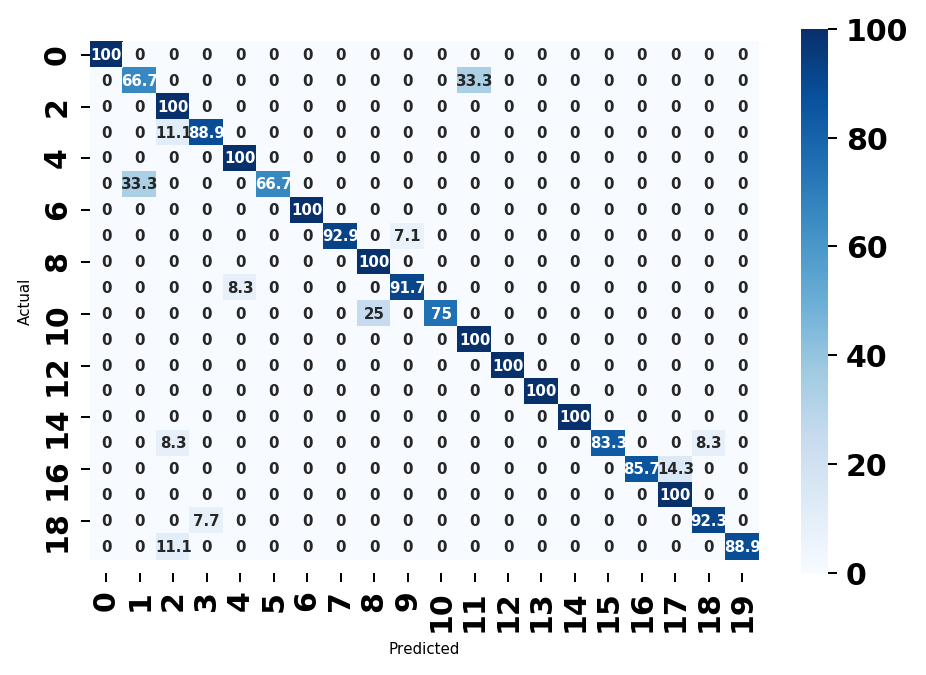

In [15]:
##### import pandas as pd
import seaborn as sn
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 6}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12) 
Y_pred = pred_030
Y_test_int = np.argmax(y_ts2,-1) 
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], normalize='index', rownames=['Actual'], 
                               colnames=['Predicted'], margins = False)\
.round(3)*100
fig = plt.figure(dpi=180)
sn.heatmap(confusion_matrix,annot=True, cmap="Blues", fmt='g') # cbar_kws={'format': '%.0f%%'},
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
# plt.xlim(b,t)
cap = plt.gcf()
plt.savefig('results/final 0to30.png', dpi = 400)
plt.show